<a href="https://colab.research.google.com/github/Manikantanemala/Deep-Learning-Based-on-Classifications-of-Fabric-types-for-Textile-Industry-Applications1/blob/main/7_1_CNN_ML_CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Level Classification

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [ ]:

BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
# settingt the seed
#seed(0)
#set_random_seed(0)
#import tensorflow
#tensorflow.random.set_seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
root_path='/content/drive/MyDrive/CNN + TL/Traing and Test Together'

In [ ]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    root_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 2000 files belonging to 8 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Corrugation of Rails',
 'Hogging of Rails',
 'No Defects',
 'Rail End Batter',
 'Rail Wear',
 'Scabbing of Rails',
 'Shelling and Black Spots',
 'Wheel Burns']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[7 4 7 6 4 7 2 6 6 2 2 3 3 5 2 7]


### Visualize some of the images from our dataset

In [ ]:
plt.figure(figsize=(20, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

125

In [ ]:
train_size = 0.8
len(dataset)*train_size

100.0

In [ ]:
train_ds = dataset.take(100)
len(train_ds)

100

In [ ]:
test_ds = dataset.skip(100)
len(test_ds)

25

In [ ]:
val_size=0.1
len(dataset)*val_size

12.5

In [ ]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [ ]:
#test_ds = test_ds.skip(5)
#len(test_ds)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

100

In [ ]:
len(val_ds)

12

In [ ]:
len(test_ds)

13

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import*
#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
100/100 [==============================] - 147s 970ms/step - loss: 2.0784 - accuracy: 0.1338 - val_loss: 2.0471 - val_accuracy: 0.1719
Epoch 2/100
100/100 [==============================] - 14s 143ms/step - loss: 2.0608 - accuracy: 0.1488 - val_loss: 2.0258 - val_accuracy: 0.1927
Epoch 3/100
100/100 [==============================] - 14s 143ms/step - loss: 2.0635 - accuracy: 0.1500 - val_loss: 1.9890 - val_accuracy: 0.1823
Epoch 4/100
100/100 [==============================] - 14s 143ms/step - loss: 2.0209 - accuracy: 0.1919 - val_loss: 2.0163 - val_accuracy: 0.1510
Epoch 5/100
100/100 [==============================] - 14s 143ms/step - loss: 2.0063 - accuracy: 0.2075 - val_loss: 1.9517 - val_accuracy: 0.2552
Epoch 6/100
100/100 [==============================] - 14s 140ms/step - loss: 1.9810 - accuracy: 0.2169 - val_loss: 1.8814 - val_accuracy: 0.2760
Epoch 7/100
100/100 [==============================] - 14s 140ms/step - loss: 1.9251 - accuracy: 0.2544 - val_loss: 1.9488 

In [ ]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 49s 15ms/step - loss: 0.9923 - accuracy: 0.7548


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [ ]:
scores

[0.9923142194747925, 0.754807710647583]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 100}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

100

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.0783839225769043,
 2.060793399810791,
 2.063504457473755,
 2.020872116088867,
 2.0062596797943115]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

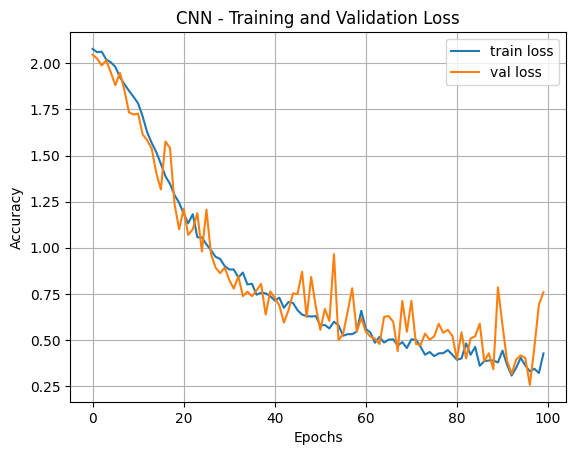

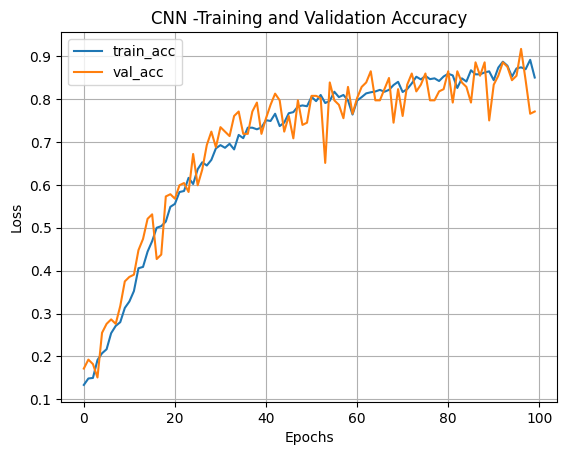

<Figure size 640x480 with 0 Axes>

In [ ]:
#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
#plt.plot(range(EPOCHS), acc, label='Training Accuracy')
#plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
plt.title('CNN - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid()
plt.show()
plt.savefig('LossVal_loss')
# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
#plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('CNN -Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.show()
plt.savefig('AccVal_acc')

### Run prediction on a sample image

first image to predict
actual label: Corrugation of Rails
1/1 [==============================] - 0s 158ms/step
predicted label: Corrugation of Rails


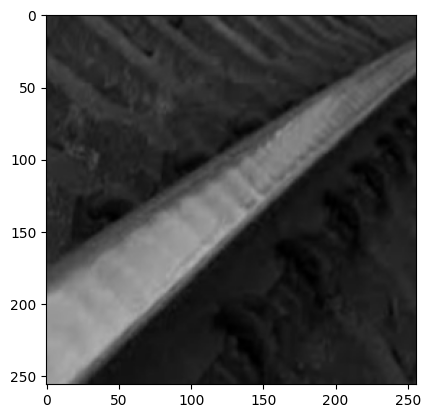

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence




**Now run inference on few sample images**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.")

        plt.axis("off")

# Implement Confusion Matrix

Confusion matrix for my problem

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the class names
class_names = dataset.class_names

# Define a list to store the true labels
y_true = []

# Define a list to store the predicted labels
y_pred = []

# Loop through the test dataset and predict the class for each image
for images, labels in test_ds:
    # Get the predicted probabilities for each class
    predictions = model.predict(images)

    # Get the predicted class for each image
    predicted_classes = np.argmax(predictions, axis=1)

    # Add the true labels to the y_true list
    y_true.extend(labels.numpy())

    # Add the predicted labels to the y_pred list
    y_pred.extend(predicted_classes)

# Convert the true and predicted labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 24ms/step


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the class names
class_names = dataset.class_names

# Define a list to store the true labels
y_true = []

# Define a list to store the predicted labels
y_pred = []

# Loop through the test dataset and predict the class for each image
for images, labels in test_ds:
    # Get the predicted probabilities for each class
    predictions = model.predict(images)

    # Get the predicted class for each image
    predicted_classes = np.argmax(predictions, axis=1)

    # Add the true labels to the y_true list
    y_true.extend(labels.numpy())

    # Add the predicted labels to the y_pred list
    y_pred.extend(predicted_classes)

# Convert the true and predicted labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 32ms/step


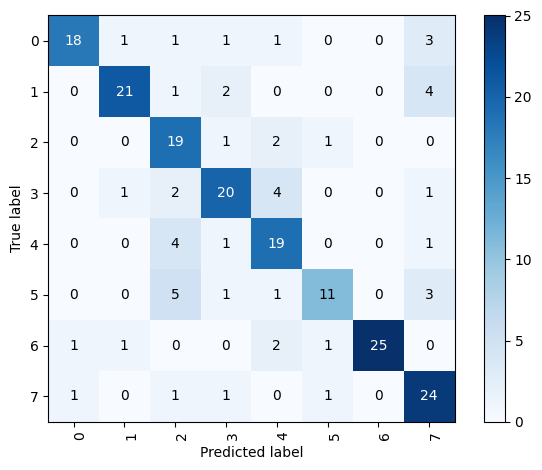

In [ ]:
from sklearn.metrics import confusion_matrix
# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=np.arange(cm.shape[1]),
       yticklabels=np.arange(cm.shape[0]),
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

Add Labels

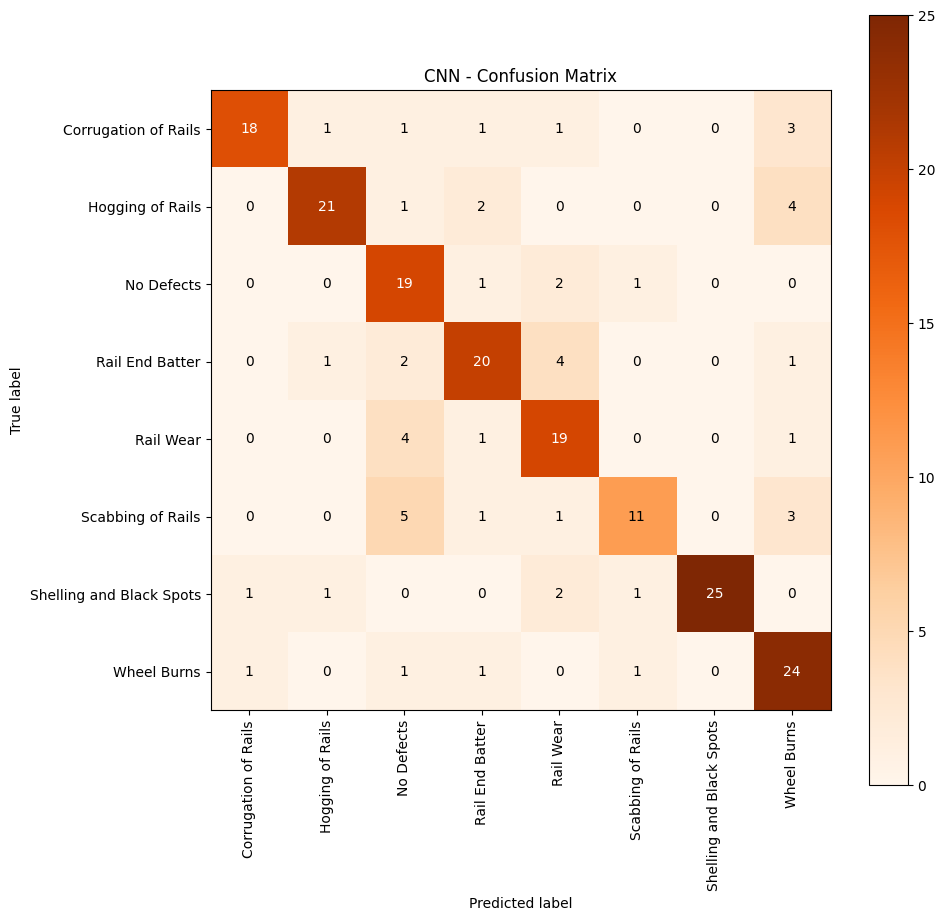

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the confusion matrix
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)

# Add the class labels to the x-axis
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)

# Add the class labels to the y-axis
ax.set_yticks(np.arange(len(class_names)))
ax.set_yticklabels(class_names)

# Add the values to the confusion matrix
thresh = cm.max() / 2.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Add the axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Add the title
ax.set_title('CNN - Confusion Matrix')

# Add a colorbar
fig.colorbar(im)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

                          precision    recall  f1-score   support

    Corrugation of Rails       0.90      0.72      0.80        25
        Hogging of Rails       0.88      0.75      0.81        28
              No Defects       0.58      0.83      0.68        23
         Rail End Batter       0.74      0.71      0.73        28
               Rail Wear       0.66      0.76      0.70        25
       Scabbing of Rails       0.79      0.52      0.63        21
Shelling and Black Spots       1.00      0.83      0.91        30
             Wheel Burns       0.67      0.86      0.75        28

                accuracy                           0.75       208
               macro avg       0.77      0.75      0.75       208
            weighted avg       0.78      0.75      0.76       208



# Plot ROC Curve - ChatGPT Code

In [ ]:
num_classes=8
from keras.utils import to_categorical
# Convert labels to one-hot encoding
y_true_onehot = to_categorical(y_true, num_classes)
y_pred_onehot = to_categorical(y_pred, num_classes)

13/13 [==============================] - 0s 13ms/step


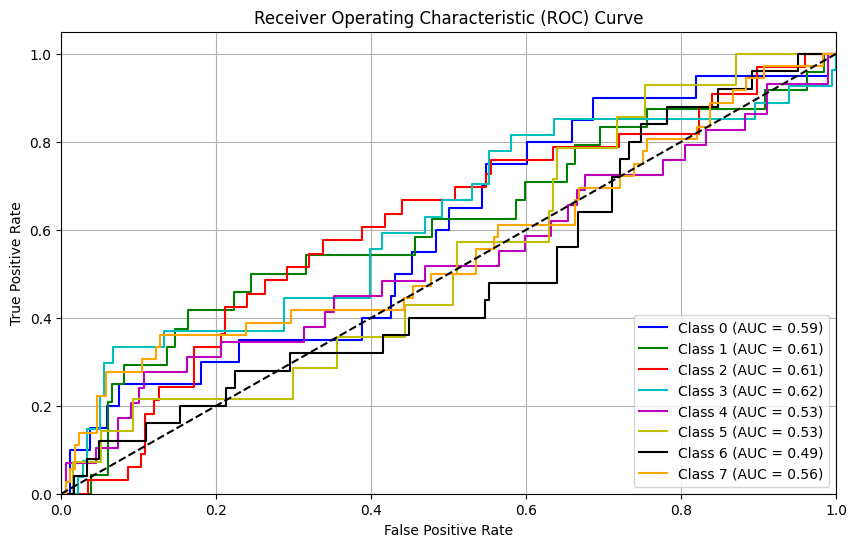

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute y_test_onehot using to_categorical
#y_test_onehot = to_categorical(y_test, num_classes)

# Compute the ROC curve and AUC for each class
y_pred_proba = model.predict(test_ds)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_pred_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']  # Define colors for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Add Class Name to ROC

13/13 [==============================] - 0s 12ms/step


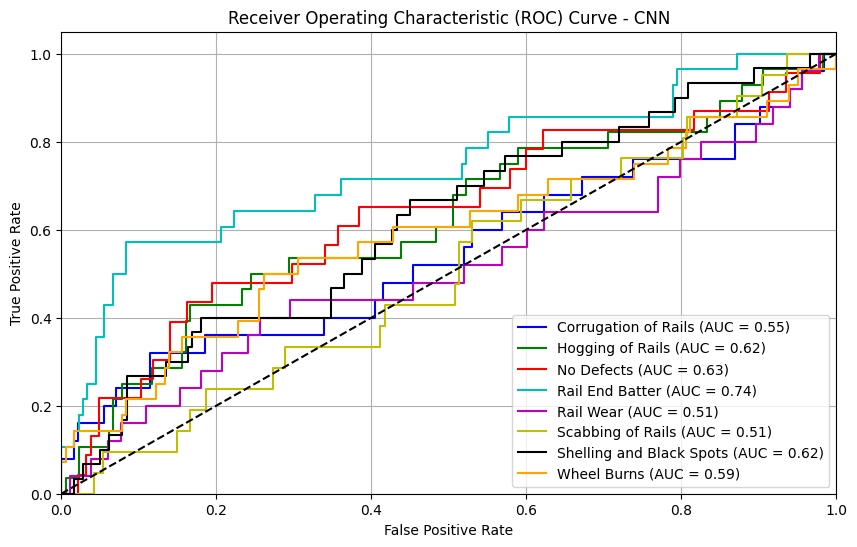

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute y_test_onehot using to_categorical
#y_test_onehot = to_categorical(y_test, num_classes)

# Compute the ROC curve and AUC for each class
y_pred_proba = model.predict(test_ds)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']  # Define colors for each class
for i in range(len(class_names)):
    #plt.plot(fpr[i], tpr[i], color=colors[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
    plt.plot(fpr[i], tpr[i], color=colors[i], label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Micro Avaeraged ROC Curve

In [ ]:
y_pred_onehot = y_pred_onehot.reshape((-1, num_classes))
y_pred = y_pred.reshape((-1, num_classes))

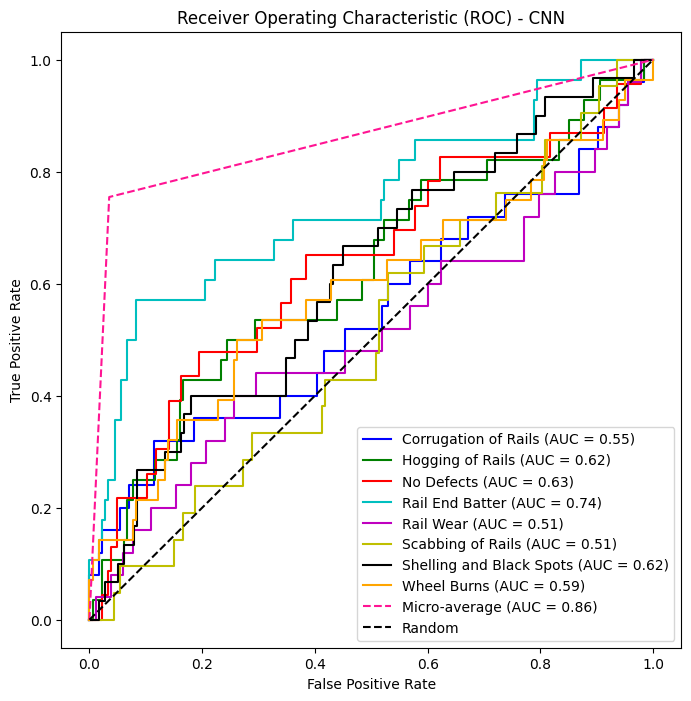

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have the true labels 'y_test_onehot' and predicted probabilities 'y_pred'

# Define the class names
class_names = ["Corrugation of Rails", "Hogging of Rails", "No Defects", "Rail End Batter", "Rail Wear", "Scabbing of Rails", "Shelling and Black Spots", "Wheel Burns"]

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_onehot.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Set colors for each class
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot micro-averaged ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle='--', label='Micro-average (AUC = {:.2f})'.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - CNN')
plt.legend(loc='lower right')

# Show the plot
plt.show()


# Plot only Micro- Average Plot

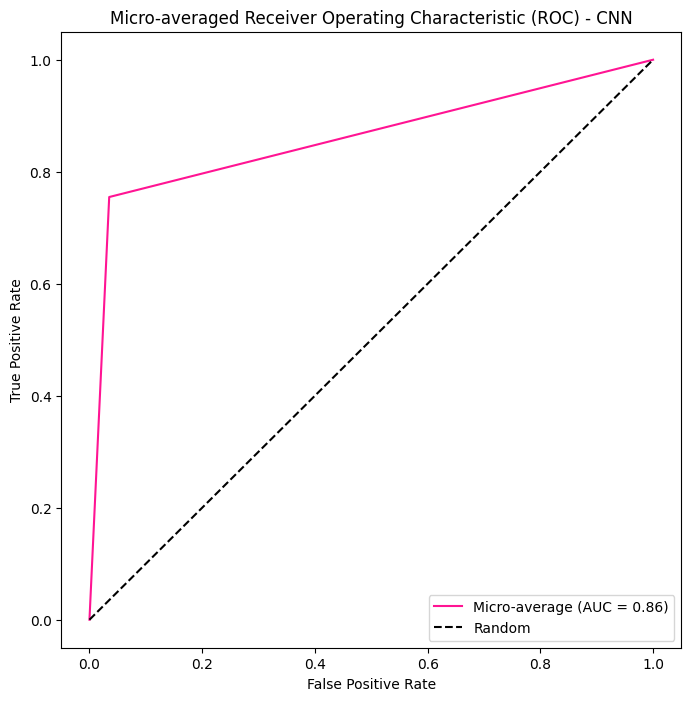

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have the true labels 'y_test_onehot' and predicted probabilities 'y_pred'

# Compute micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_onehot.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-averaged ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_micro, tpr_micro, color='deeppink', label='Micro-average (AUC = {:.2f})'.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-averaged Receiver Operating Characteristic (ROC) - CNN')
plt.legend(loc='lower right')

# Show the plot
plt.show()
